In [15]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(',')) 

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical, multi_gpu_model, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

config = tf.ConfigProto() 
config.gpu_options.allow_growth=True 
session = tf.Session(config=config)
K.set_session(session)


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
from keras_helper import *
from skimage.transform import resize
from sklearn.metrics import mean_squared_error as mse

### Read test data

In [17]:
X_test = np.load('data/X_test.npy')
Y_I_test = np.load ('data/Y_I_test.npy')
Y_phi_test = np.load('data/Y_phi_test.npy')
nltest = int(Y_I_test.shape[0]**0.5)

### Load the model from the epoch with lowest validation error

In [18]:
wt_path = 'wts4' #Where to read network weights
min_epoch = np.load('%s/min_epoch.npy' %wt_path)
from keras.models import Model, load_model
model=load_model('%s/weights.%02d.hdf5' %(wt_path,min_epoch))
print ("Loaded model from epoch:%d" %min_epoch)

Loaded model from epoch:66


### Make prediction using the diffraction data alone

In [19]:
preds_intens=(model.predict(X_test))
print (preds_intens[0].shape)

(3600, 64, 64, 1)


# Plot some instances of the test data, it's FT and the CNN prediction

<Figure size 432x288 with 0 Axes>

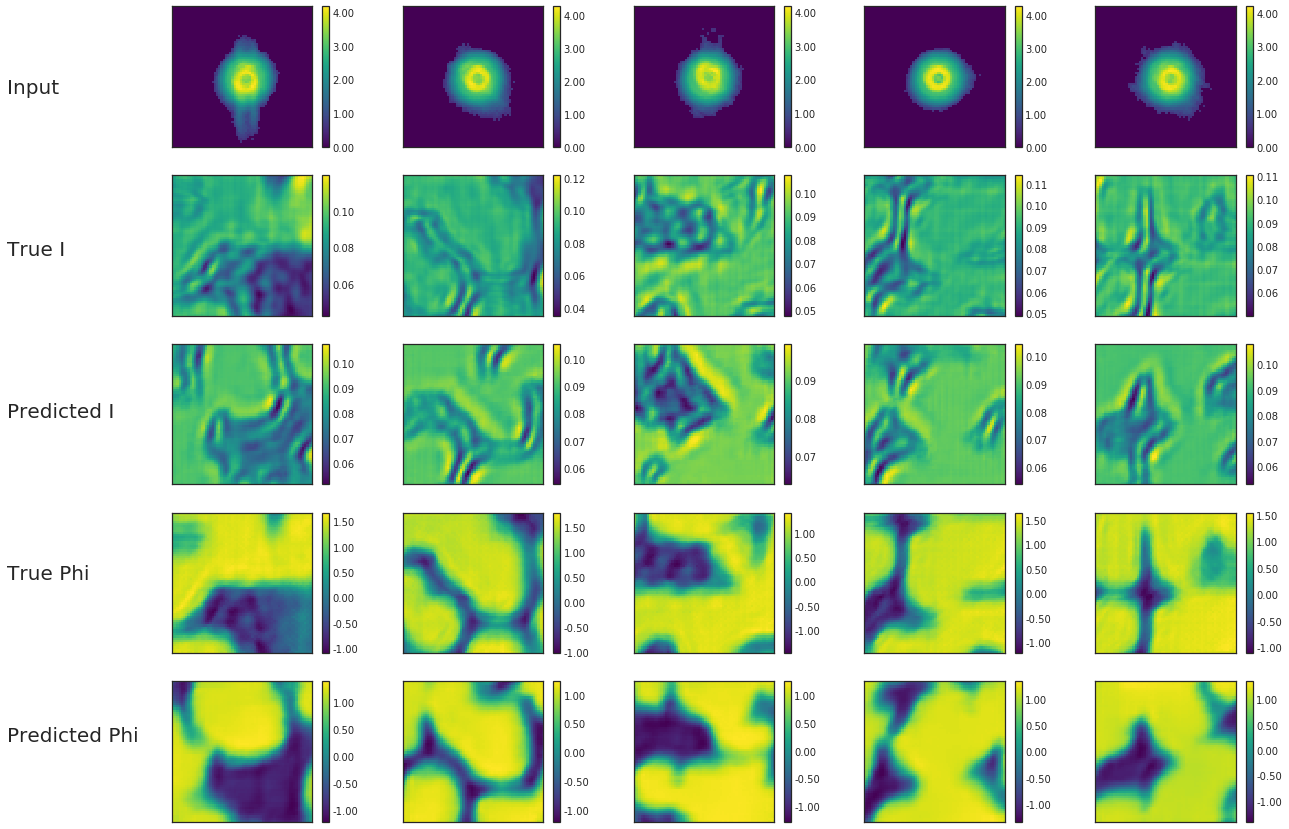

In [20]:
h,w = 64,64
ntest=preds_intens[0].shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(5,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.65, "True I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.35, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.2, "Predicted Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[3,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[4,i].imshow(preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
plt.show()

## Plot NN predictions from adjacent scan points to see variation 

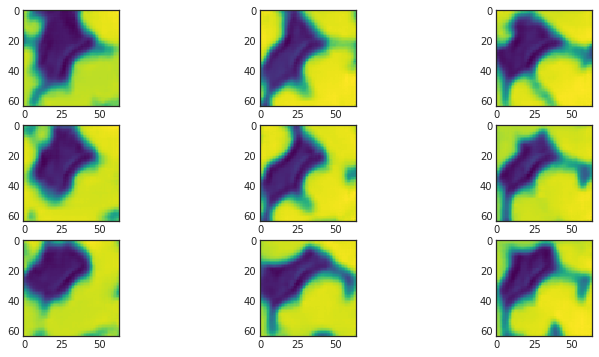

In [21]:
tst_side = 60
fig, ax = plt.subplots(3,3, figsize=(12,6))
ax[0,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,9]))
ax[0,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,10]))
ax[0,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,11]))
ax[1,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,9]))
ax[1,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,10]))
ax[1,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,11]))
ax[2,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,9]))
ax[2,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,10]))
ax[2,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,11]))

# Stitch predictions together

In [22]:
point_size = 3
overlap = 4*point_size

In [23]:

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = preds_intens[0].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


In [24]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = preds_intens[1].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


In [25]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

## Plot the ePIE reconstruction, the PtychoNN prediction and the difference between the two

In [26]:
amp = Y_I_test.reshape(nltest,nltest,64,64)
ph = Y_phi_test.reshape(nltest,nltest,64,64)

(-0.5, 59.5, 59.5, -0.5)

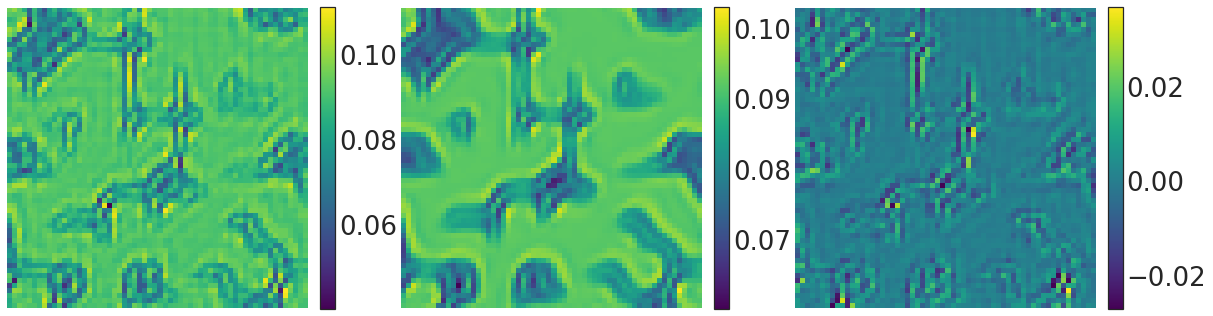

In [27]:
minc = min(stitched_amp_down.min(),amp[:,:,32,32].min()) #Set common color range respecting bounds of both
maxc = max(stitched_amp_down.max(),amp[:,:,32,32].max()) 

plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(1,3,figsize=(20,12))

im=ax[0].imshow(amp[:,:,32,32])#,vmin=minc, vmax=maxc)
ax[0].axis('off')
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)

im=ax[1].imshow(stitched_amp_down)#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_amp_down-amp[:,:,32,32])
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

(-0.5, 59.5, 59.5, -0.5)

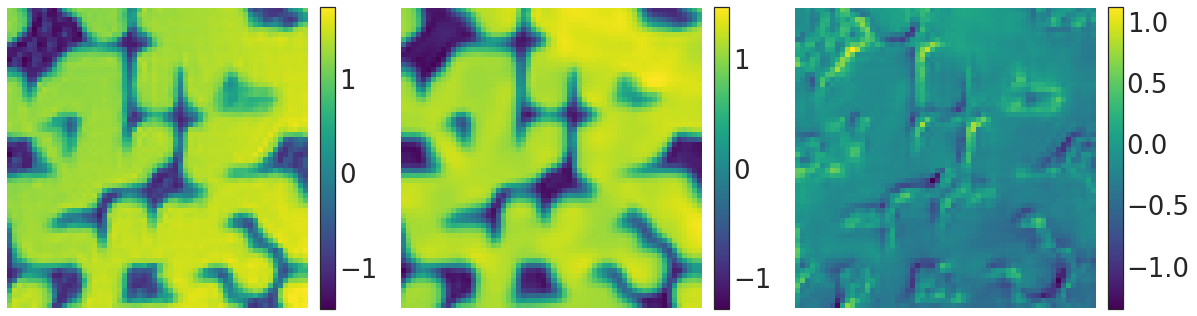

In [28]:
minc = min(stitched_phase_down.min(),ph[:,:,32,32].min()) #Set common color range respecting bounds of both
maxc = max(stitched_phase_down.max(),ph[:,:,32,32].max()) 

fig, ax = plt.subplots(1,3,figsize=(20,10))

im=ax[0].imshow(ph[:,:,32,32])#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
ax[0].axis('off')

im=ax[1].imshow(stitched_phase_down)#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_phase_down-ph[:,:,32,32])
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

### Quantify MSE error between phase retrieval and PtychoNN

In [68]:
print ("MSE in amplitude: ", mse(stitched_amp_down, ph[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, ph[:,:,32,32]))

MSE in amplitude:  1.2448773707282499
MSE in phase:  0.08814609204169972
